# Initialization

In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import geopandas
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import shutil
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import sys
import os
from zipfile import ZipFile
import csv
import random
import math
from math import isnan 

In [2]:
fiji_path = '/home/saka/sw/local/fiji/2023'
memory = 30

scyjava.config.add_option('-Xmx'+str(memory)+'g')
ij = imagej.init(fiji_path, mode='interactive')
ij.ui().showUI()
ij.getVersion()

showPolygonRoi = scyjava.jimport('ij.gui.PolygonRoi')
Overlay = scyjava.jimport('ij.gui.Overlay')
Regions = scyjava.jimport('net.imglib2.roi.Regions')
LabelRegions = scyjava.jimport('net.imglib2.roi.labeling.LabelRegions')
ZProjector = scyjava.jimport('ij.plugin.ZProjector')()
Duplicator = scyjava.jimport('ij.plugin.Duplicator')()
TrackMate = scyjava.jimport('fiji.plugin.trackmate.TrackMate')
ov = Overlay()
Model =  scyjava.jimport('fiji.plugin.trackmate.Model')
Settings= scyjava.jimport('fiji.plugin.trackmate.Settings')
Settings= scyjava.jimport('fiji.plugin.trackmate.Settings')
TrackMate = scyjava.jimport('fiji.plugin.trackmate.TrackMate')
Logger= scyjava.jimport('fiji.plugin.trackmate.Logger')
DetectorKeys= scyjava.jimport('fiji.plugin.trackmate.detection.DetectorKeys') 
ExportTracksToXML= scyjava.jimport('fiji.plugin.trackmate.action.ExportTracksToXML') 
TmXmlWriter= scyjava.jimport('fiji.plugin.trackmate.io.TmXmlWriter')
TmXmlReader = scyjava.jimport('fiji.plugin.trackmate.io.TmXmlReader')
LogRecorder = scyjava.jimport('fiji.plugin.trackmate.util.LogRecorder')
SparseLAPTrackerFactory= scyjava.jimport('fiji.plugin.trackmate.tracking.jaqaman.SparseLAPTrackerFactory')
TMUtils = scyjava.jimport('fiji.plugin.trackmate.util.TMUtils')
HyperStackDisplayer = scyjava.jimport('fiji.plugin.trackmate.visualization.hyperstack.HyperStackDisplayer')
SelectionModel = scyjava.jimport('fiji.plugin.trackmate.SelectionModel')
CellposeDetectorFactory = scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeDetectorFactory')
FeatureFilter = scyjava.jimport('fiji.plugin.trackmate.features.FeatureFilter')
DisplaySetting = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettings')
DisplaySettingsIO = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettingsIO')
CaptureOverlayAction = scyjava.jimport('fiji.plugin.trackmate.action.CaptureOverlayAction')
PretrainedModel= scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeSettings.PretrainedModel')
ThresholdDetectorFactory= scyjava.jimport('fiji.plugin.trackmate.detection.ThresholdDetectorFactory')
TrackScheme = scyjava.jimport('fiji.plugin.trackmate.visualization.trackscheme.TrackScheme')
TrackTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.TrackTableView')
AllSpotsTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.AllSpotsTableView')
PretrainedModel = scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeSettings.PretrainedModel')
Logger= scyjava.jimport('fiji.plugin.trackmate.Logger')
DetectorKeys= scyjava.jimport('fiji.plugin.trackmate.detection.DetectorKeys') 
ExportTracksToXML= scyjava.jimport('fiji.plugin.trackmate.action.ExportTracksToXML') 
LogRecorder = scyjava.jimport('fiji.plugin.trackmate.util.LogRecorder')
SparseLAPTrackerFactory= scyjava.jimport('fiji.plugin.trackmate.tracking.jaqaman.SparseLAPTrackerFactory')
TMUtils = scyjava.jimport('fiji.plugin.trackmate.util.TMUtils')
HyperStackDisplayer = scyjava.jimport('fiji.plugin.trackmate.visualization.hyperstack.HyperStackDisplayer')
SelectionModel = scyjava.jimport('fiji.plugin.trackmate.SelectionModel')
CellposeDetectorFactory = scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeDetectorFactory')
FeatureFilter = scyjava.jimport('fiji.plugin.trackmate.features.FeatureFilter')
DisplaySetting = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettings')
DisplaySettingsIO = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettingsIO')
CaptureOverlayAction = scyjava.jimport('fiji.plugin.trackmate.action.CaptureOverlayAction')
PretrainedModel= scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeSettings.PretrainedModel')
ThresholdDetectorFactory= scyjava.jimport('fiji.plugin.trackmate.detection.ThresholdDetectorFactory')
TrackScheme = scyjava.jimport('fiji.plugin.trackmate.visualization.trackscheme.TrackScheme')
TrackTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.TrackTableView')
AllSpotsTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.AllSpotsTableView')
PretrainedModel = scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeSettings.PretrainedModel')
IJRoiExporter = scyjava.jimport('fiji.plugin.trackmate.action.IJRoiExporter')
rm = ij.RoiManager.getRoiManager()

# Functions

In [3]:
def open_raw_image(raw_image_path):
    '''
    This function loads the raw image file into ImageJ from the path specified. The raw image path should be a .czi file.
    '''
    raw_image = ij.io().open(raw_image_path)
    return raw_image

def process_images(directory_path, raw_image, method='max all', wanted_z=2, dimensions=[4,1,121]):
    '''
    This function retrieves a multi-channel, single-slice T-stack image at the specified z-value and saves it as channels.tif.
    It also creates a z-projection from the raw image using the method specified and saves it as [method]_channels.tif. The default method is a "max" z-projection.
    '''
    imp = ij.py.to_imageplus(raw_image)
    channels = raw_image[:, :, :, wanted_z, :]
    final_image = ij.py.to_imageplus(channels)
    final_image.setDimensions(dimensions[0], dimensions[1], dimensions[2])
    channels_image = directory_path + "channels.tif"
    saved = ij.IJ.save(final_image, ij.py.to_java(channels_image))
    zproject = ZProjector.run(imp, method)
    zproject.setDimensions(dimensions[0], dimensions[1], dimensions[2])
    max_channels = directory_path + "max_channels.tif"
    ij.IJ.saveAs(zproject, "Tiff", ij.py.to_java(max_channels))
    zproject_sum = ZProjector.run(imp, "sum all")
    sum_channels = directory_path + "sum_channels.tif"
    ij.IJ.saveAs(zproject_sum, "Tiff", ij.py.to_java(sum_channels))
    return channels_image, max_channels

def process_channels(directory_path, raw_image, channel_dict={'LC3':0,'LV':2,'bact':1}, dimensions=[1, 11, 121]):
    '''
    This function isolates and saves single-channel videos from the raw image for each desired channel specified in channel_dict. 
    Note on channel_dict: channel_dict is a dictionary where each key is a string that represents a channel name and the corresponding values are integers equal to the corresponding channel number in the multi-channel video. 
    '''
    for c in channel_dict:
        channel = raw_image[:, :, channel_dict[c], :, :]
        c_image = ij.py.to_imageplus(channel)
        c_image.setDimensions(dimensions[0], dimensions[1], dimensions[2])
        result_path = f"{directory_path}/channel_{c}.tif"
        ij.IJ.saveAs(c_image, "Tiff", ij.py.to_java(result_path))

def track_cells(channels_image, directory_path, dsettings, tsettings, distance=2048, known=202.93, unit="µm"):
    '''
    This function leverages ImageJ's Trackmate plugin to track the cells in channels.tif. It uses a custom-trained Cellpose model for segmentation (with detection parameters specified in dsettings), and the LAP Tracker algorithm for tracking (with tracking parameters specified in tsettings).
    The function saves the Trackmate XML model as well as a CSV file of the tracks as output. The function also takes as input the scale of the image.
    '''
    # Open Image
    imp = ij.IJ.openImage(channels_image)
    imp.show()
    ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known} unit={unit}");')    
    # Create Model
    model = Model()
    settings = Settings(imp)   
    # Detector
    settings.detectorFactory = CellposeDetectorFactory()
    for parameter, value in dsettings.items():
        settings.detectorSettings[parameter] = value
    # Tracker
    settings.trackerFactory = SparseLAPTrackerFactory()
    settings.trackerSettings = settings.trackerFactory.getDefaultSettings()
    for parameter, value in tsettings.items():
        settings.trackerSettings[parameter] = value
    # Execute Tracking
    trackmate = TrackMate(model, settings)
    ok = trackmate.checkInput()
    if not ok:
        sys.exit(str(trackmate.getErrorMessage()))
    ok = trackmate.process()
    if not ok:
        sys.exit(str(trackmate.getErrorMessage()))
    selectionModel = SelectionModel(model)  
    # Display
    ds = DisplaySettingsIO.readUserDefault()
    displayer = HyperStackDisplayer(model, selectionModel, imp, ds)
    displayer.render()
    displayer.refresh()
    trackscheme = TrackScheme(model, selectionModel, ds)
    trackscheme.render()
    # Save Data
    outFile = Path(directory_path+"exportModel.xml")
    writer = TmXmlWriter(outFile)
    writer.appendModel(model)
    writer.appendSettings(settings)
    writer.writeToFile()
    csvFileTracks = Path(directory_path+"exportTracks.csv")
    trackTableView = TrackTableView(model, selectionModel, ds)
    trackTableView.getSpotTable().exportToCsv(csvFileTracks)
    return csvFileTracks, model, imp

def sort_trackmate_export(tm_tracks_csv, directory_path):
    '''
    This function sorts the exported CSV file from Trackmate so that the cells are ordered by track ID and frame number. It saves the sorted file to the directory path.
    '''
    df = pandas.read_csv(tm_tracks_csv)
    df.drop([0, 1, 2], axis=0, inplace=True)
    df = df.reset_index(drop=True)
    for index, row in df.iterrows():
        df.at[index, 'TRACK_ID'] = int(row['TRACK_ID'])
        df.at[index, 'FRAME'] = int(row['FRAME'])
    df.sort_values(by=['TRACK_ID', 'FRAME'], inplace=True, ignore_index=True)
    df.to_csv(directory_path+"exportTracks_edited.csv", index=False)
    output = directory_path+"exportTracks_edited.csv"
    return output

def get_cell_rois(directory_path, model, imp):
    '''
    This function exports the cell ROIs from Trackmate and saves them in a zip file. 
    '''
    model.setLogger(Logger.IJ_LOGGER)
    logger = Logger.IJ_LOGGER
    exporter = IJRoiExporter(imp, logger)
    exporter.export(model.getSpots().iterable(True))
    rm.save(directory_path+"RoiSet_cells.zip");
    rm.runCommand(imp,"Delete");
    with ZipFile(directory_path+"RoiSet_cells.zip", 'r') as zip: 
        zip.extractall(path=directory_path+"rois")
    output = directory_path+"rois/"
    return output

def create_tracks_csv(sorted_tm_tracks_csv, directory_path):
    '''
    This function creates a CSV file (da_Tracks.csv) where each row is a separate track and lists the ROI Manager indices that correspond to cell ROIs in that track.
    '''
    data = pandas.read_csv(sorted_tm_tracks_csv)
    file = open(directory_path+'da_Tracks.csv', 'w', newline='')
    csv_writer = csv.writer(file)
    current_track = 0
    first = True
    string = ''
    for index, row in data.iterrows():
        if int(row['TRACK_ID']) == current_track:
            if first:
                string = f'{index+1}'
                first = False
            else:
                string = string + ", " + f'{index+1}'
        else:
            csv_writer.writerow([string])
            string = f'{index+1}'
            current_track += 1  
    file.close()
    output = directory_path+"da_Tracks.csv"
    return output

def add_rois(sorted_tm_tracks_csv, roiset):
    '''
    This function adds cell ROIs (from the saved zip file) into the ImageJ ROI Manager *in order*. 
    It is imperative to run this function to load the ROI Manager (as opposed to dragging and dropping the RoiSet into ImageJ GUI) in order to preserve the order of the ROIS and ensure consistency with ROI labels given in da_Tracks.csv.
    '''
    df = pandas.read_csv(sorted_tm_tracks_csv)
    for index, row in df.iterrows():
        file = row['LABEL'] + '.roi'
        rm.open(roiset+file)

def apply_cell_overlays(directory_path, max_channels, tracks_csv):
    '''
    This function allows for visual quality-control of the cell-tracking step by displaying the max z-projection video and applying a colored overlay to the cells in each track. 
    It is a useful aid while selecting cells of interest since cells of the same track remain the same color from frame to frame.
    '''
    imp = ij.IJ.openImage(max_channels)
    imp.show()

    data_info = {}
    for element in range(len(imp.dims)):
        name = imp.dims[element]
        data_info[name] = imp.shape[element]
    num_channel = data_info['C'] + 1
    for n in range (1, num_channel):
        imp.setC(n)
        ij.IJ.resetMinAndMax(imp)
    imp.setC(1)
    ij.IJ.run(imp, "Green", "");
    imp.setC(2)
    ij.IJ.run(imp, "Red", "");
    imp.setC(3)
    ij.IJ.run(imp, "Grays", "");

    df2 = pandas.read_csv(tracks_csv, header=None)
    colors = ["black", "blue", "cyan", "green", "magenta", "orange", "red", "white", "yellow"]
    for index, row in df2.iterrows():
        l = row[0].split(", ")
        random_color = random.choice(colors)
        for cell in l:
            cell_index = int(cell)
            roi = rm.select(cell_index-1)
            overlay_command = f"Overlay.addSelection('{random_color}', 5);"
            ij.py.run_macro(overlay_command)

def isolate_single_cell(directory_path, channel_dict, tracks_csv, cells_desired=[]):
    '''
    This function isolates and saves single-cell, single-channel videos for each cell track specified in cells_desired.
    Videos with the "bact" signal are saved in directory_path/bact/ and videos for all other channels in channel_dict are saved in directory_path/other/.
    Notes on cells_desired: 
        To duplicate all of the segmented cells in the video, input an empty list for cells_desired.
            Ex. cells_desired = [] will return single-cell videos for every row in da_Tracks.
        Otherwise, cells_desired should be a list where each item is either a) an integer corresponding to the row number of the desired track in da_Tracks.csv or b) a list of integers corresponding to row numbers of cell tracks that should be concatenated (useful for fragmented tracks)
            Ex. cells_desired = [1, 3, 7, [9,10,11]] will return single-cell videos for row 1, row 3, and row 7 of da_Tracks, as well as a single-cell video that merges row 9, row 10, and row 11's cell tracks.
    '''
    bact = directory_path+"bact/"
    other = directory_path+"other/"
    if not os.path.exists(bact):
        os.makedirs(bact)
    if not os.path.exists(other):
        os.makedirs(other)
    signal_list = list(channel_dict)
    df2 = pandas.read_csv(tracks_csv, header=None)
    if len(cells_desired) == 0:
        for n in range(1,len(df2)+1):
            cells_desired.append(n)
    for signal in signal_list:
        image_path = Path(f"{directory_path}/channel_{signal}.tif").as_posix()
        imp = ij.IJ.openImage(image_path)
        ij.ui().show(imp)
        w = scyjava.jimport('ij.WindowManager')
        df = pandas.read_csv(tracks_csv, header=None)
        for cell_desired in cells_desired:
            nums = []
            if isinstance(cell_desired, int):
                row = df.iloc[cell_desired-1]
                nums = row[0].split(", ")
            elif isinstance(cell_desired, list):
                for c in cell_desired:
                    row = df.iloc[c-1]
                    nums += row[0].split(", ")
            arr = []
            for x in nums:
                arr.append(int(x))
            for i in range(len(arr)):
                cell = arr[i]
                roi = rm.getRoi(cell-1)
                roi2 = rm.select(cell-1)
                frame = roi.getTPosition()
                if i == 0:
                    ij.IJ.run("Duplicate...", "title=Stack_reg_image duplicate frames="+str(frame))
                    ij.IJ.run("Clear Outside", "stack")
                    ij.IJ.selectWindow(imp.getTitle())
                elif i > 0:
                    ij.IJ.run("Duplicate...", "title=channels duplicate frames="+str(frame))
                    ij.IJ.run("Clear Outside", "stack")
                    ij.IJ.run("Concatenate...", "title=Stack_reg_image open image1=Stack_reg_image image2=channels image3=[-- None --]")
                    ij.IJ.selectWindow(imp.getTitle())
            new_vid =  w.getImage("Stack_reg_image")
            if signal == "bact":
                ij.IJ.save(new_vid, bact+"cell_"+str(cell_desired)+".tif")
            else:
                ij.IJ.save(new_vid, other+signal+"_cell_"+str(cell_desired)+".tif")
            w.getImage("Stack_reg_image").close()
            ij.IJ.selectWindow(imp.getTitle())
        ij.py.run_macro('close("*")')
    return bact, other

def get_bacteria_rois(bact, directory_path):
    '''
    This function processes every single-cell video in the input folder bact. It uses thresholding in ImageJ to detect bacterial ROIs within the video and saves them in a zip file with the cell name. 
    The function also creates and saves a CSV file of all of the bacterial ROIs for each cell video.
    '''
    rm.runCommand("Delete")
    file_pattern = os.path.join(bact, "*.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image = ij.io().open(file_path)
        shown = ij.ui().show(image)
        roi_collection = """
        run("Duplicate...", "duplicate");
        run("Smooth", "stack");
        run("Smooth", "stack");
        setAutoThreshold("Default dark no-reset");
        run("Threshold...");
        setThreshold(5, 255);
        setOption("BlackBackground", true);
        run("Convert to Mask", "black");  
        run("Analyze Particles...", "size=1-Infinity add stack");
        run("Set Measurements...", "area centroid stack redirect=None decimal=2");
        nbArea=roiManager("count")
        for (i=0; i<nbArea; i++) {
    		roiManager("Select", i);
    		run("Measure");	
        }
        close();
        close();
        """
        rois = ij.py.run_macro(roi_collection)
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        rm.runCommand("Select All")
        rm.runCommand("Save", f"{bact}" + f"{f_name}.zip") # this saves the ROIs as a zip file
        rm.runCommand("Delete")
        measurements = ij.ResultsTable.getResultsTable() # call of the table
        measurements_table = ij.convert().convert(measurements, scyjava.jimport('org.scijava.table.Table')) # conversion to a java table object
        table = ij.py.from_java(measurements_table) # Conversion into a python dataframe from Java
        output_path = Path(f"{bact}{f_name}.csv") # save giving a name matching the opened image
        table.to_csv(output_path)
        ij.py.run_macro(""" 
            title = Table.title();
            selectWindow(title);
            run("Close");
        """)

def track_bacteria(bact, directory_path, dsettings, quality_filter, tsettings, display=False):
    '''
    This function leverages ImageJ's Trackmate plugin to track the bacteria within each single-cell video provided in the input folder bact. 
    It uses the Tresholding Detector for segmentation (with detection parameters specified in dsettings), and the LAP Tracker algorithm for tracking (with tracking parameters specified in tsettings). The function also takes as input the desired quality filter on the detected spots.
    The function saves the Trackmate XML model as well as a CSV file of the tracks for each cell in bact/Output/.
    '''
    out = directory_path+"Output/"
    if not os.path.exists(out):
        os.makedirs(out)
    for image in os.listdir(bact):
        if (image[len(image)-4:] == ".tif"):
            # Open Image
            imp = ij.IJ.openImage(bact + image)
            imp.show()
            ij.IJ.run("Smooth", "stack")
            # Create Model
            model = Model()
            settings = Settings(imp)
            # Detector
            settings.detectorFactory = ThresholdDetectorFactory()
            for parameter, value in dsettings.items():
                settings.detectorSettings[parameter] = value
            filter1 = FeatureFilter('QUALITY', quality_filter, True)
            settings.addSpotFilter(filter1)
            print(settings.detectorSettings)
            # Tracker
            settings.trackerFactory = SparseLAPTrackerFactory()
            settings.trackerSettings = settings.trackerFactory.getDefaultSettings()
            for parameter, value in tsettings.items():
                settings.trackerSettings[parameter] = value
            # Execute Tracking
            trackmate = TrackMate(model, settings)
            ok = trackmate.checkInput()
            if not ok:
                sys.exit(str(trackmate.getErrorMessage()))
            ok = trackmate.process()
            if not ok:
                sys.exit(str(trackmate.getErrorMessage()))
            selectionModel = SelectionModel(model)
            # Display
            ds = DisplaySettingsIO.readUserDefault()
            if display:
                displayer = HyperStackDisplayer(model, selectionModel, imp, ds)
                displayer.render()
                displayer.refresh()
                trackscheme = TrackScheme(model, selectionModel, ds)
                trackscheme.render()
            # Save Data
            outFile = Path(out+image+"_exportModel.xml")
            writer = TmXmlWriter(outFile)
            writer.appendModel(model)
            writer.appendSettings(settings)
            writer.writeToFile()
            csvFileTracks = Path(out+image+"_exportTracks.csv")
            trackTableView = TrackTableView(model, selectionModel, ds)
            trackTableView.getSpotTable().exportToCsv(csvFileTracks)
    ij.py.run_macro('close("*")')

def xref_locations(first, second, first_x='POSITION_X', first_y='POSITION_Y', first_z='POSITION_Z',
                   second_x='X', second_y='Y', second_z='Slice',
                   max_dist=20, verbose=False):
    pairwise_elements = pandas.DataFrame()
    first_measurements = pandas.read_csv(first)
    first_measurements = first_measurements.drop([0,1,2])
    second_measurements = pandas.read_csv(second)
    first_gdf = geopandas.GeoDataFrame(
        first_measurements,
        geometry=geopandas.points_from_xy(first_measurements[first_x],
                                          first_measurements[first_y],
                                          first_measurements[first_z]))
    second_gdf = geopandas.GeoDataFrame(
        second_measurements,
        geometry=geopandas.points_from_xy(second_measurements[second_x],
                                          second_measurements[second_y],
                                          second_measurements[second_z]))
    ti_rows = first_gdf.shape[0]
    tj_rows = second_gdf.shape[0]
    for ti_row in range(0, ti_rows):
        if verbose:
            print(f"On row: {ti_row}")
        ti_element = first_gdf.iloc[[ti_row, ]]
        # Get the frame of the current element
        ti_frame = int(ti_element['FRAME'].values[0])  # Convert to integer values in 'FRAME' column
        # Filter second_gdf to only include elements with the same frame
        same_frame_elements = second_gdf[second_gdf['Frame'] == (ti_frame + 1)]
        
        titj = geopandas.sjoin_nearest(ti_element, same_frame_elements,
                                       distance_col="pairwise_dist",
                                       max_distance=max_dist)
        chosen_closest_dist = titj.pairwise_dist.min()
        if (isnan(chosen_closest_dist)):
            print(f"This element has no neighbor within {max_dist}.")
        else:
            chosen_closest_cell = titj.pairwise_dist == chosen_closest_dist
            chosen_closest_row = titj[chosen_closest_cell]
            pairwise_tmp = pandas.concat([pairwise_elements, chosen_closest_row])
            pairwise_elements = pairwise_tmp
    return pairwise_elements

def merge_trackmate_rois(bact, directory_path):
    '''
    This function seeks to assign bacterial ROIs to tracks by merging the results of tracking (via Trackmate) and ROI detection (via Thresholding in ImageJ). It matches ROIs to spots detected in Trackmate based on the nearest centroid.
    For each cell, the function saves a CSV file of tracks and their corresponding ROIs in a folder called grouped.
    '''
    file_pattern = os.path.join(bact, "*.tif")
    file_list = glob.glob(file_pattern)
    out = directory_path+"grouped/"
    if not os.path.exists(out):
        os.makedirs(out)
    for file_path in file_list:
        filename = os.path.basename(file_path)
        filename2 = os.path.splitext(filename)[0]
        first = Path(f"{directory_path}/Output/{filename}_exportTracks.csv").as_posix()
        second = Path(f"{bact}/{filename2}.csv").as_posix()
        pairwise = xref_locations(first, second, 
                              first_x='POSITION_X', 
                              first_y='POSITION_Y', 
                              first_z='POSITION_Z', 
                              second_x='X', 
                              second_y='Y', 
                              second_z='Slice', 
                              verbose=False)
        grouped = pairwise.groupby('TRACK_ID')['Unnamed: 0'].apply(list).reset_index()
        grouped.rename(columns={'Unnamed: 0': 'object_ID_list'}, inplace=True)
        final_csv = Path(f"{directory_path}/grouped/{filename2}_grouped.csv")
        grouped.to_csv(final_csv)
    return out

def apply_bact_overlays(bact, grouped):
    '''
    This function allows for visual quality-control of the bacterial-tracking step by adding colored overlays to the bacterial tracks in each single-cell video. Bacterial clusters of the same track remain the same color from frame to frame.
    All of the overlayed videos are saved in the folder bact with the title [cell_number]_overlay.tif.
    '''
    file_pattern = os.path.join(bact, "*.tif")
    file_list = glob.glob(file_pattern)
    colors = ["blue", "cyan", "green", "magenta", "orange", "red", "yellow"]
    for file_path in file_list: # cycle through images, open them and open the matching "grouped' csv file
        imp = ij.IJ.openImage(file_path)
        ij.ui().show(imp)
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        input_csv = Path(f"{grouped}/{f_name}_grouped.csv")
        df = pandas.read_csv(input_csv)
        pouet = df['object_ID_list']
        input_ROI = Path(f"{bact}/{f_name}.zip")
        rm.open(f"{input_ROI}")
        for i in range(len(pouet)):
            single_row = df.iloc[i]
            random_color = random.choice(colors)
            row_cellids = single_row.object_ID_list
            row_cleaned = row_cellids.strip('[').strip(']')
            row_array = row_cleaned.split(', ')
            for cell in row_array:
                cell_index = int(cell)
                roi = rm.select(cell_index)
                overlay_command = f"Overlay.addSelection('{random_color}',2);"
                ij.py.run_macro(overlay_command)
        ij.py.run_macro("setMinAndMax(0, 50);")
        ij.py.run_macro("run('Flatten', 'stack');")
        method = 'max all'
        z_projector_result = ZProjector.run(imp, method)
        z_collapsed_image = ij.py.from_java(z_projector_result)
        z_collapsed_dataset = ij.py.to_dataset(z_projector_result)
        result_path = os.path.splitext(file_path)[0] + "_overlay.tif"
        ij.io().save(z_collapsed_dataset, result_path)
        ij.py.run_macro("close();")
        ij.py.run_macro("roiManager('Select All');")
        rm.runCommand("Delete")

def measure_signals(cois, directory_path, grouped, bact, other):
    '''
    This function measures the amount of signal within each bacterial ROI for each single-cell video in bact. The signals to be measured are specified in the input list cois (short for channels of interest).
    The function saves the results as CSV files for each channel and cell in directory_path/measurement.
    '''
    file_pattern = os.path.join(other, "*.tif")
    file_list = glob.glob(file_pattern)
    out = directory_path+"/measurement"
    if not os.path.exists(out):
        os.makedirs(out)
    #set measurement 
    set_string = f'Set Measurements...'
    measure_string = f'mean stack redirect=None decimal=2'
    ij.IJ.run(set_string, measure_string)
    prefix_bact = 'bact'
    # preparation of variables for file name call automation
    for file_path in file_list:
        f_name = os.path.basename(file_path)
        basename = os.path.splitext(f_name)[0]
        if basename.startswith(cois[0]):
            corename = basename.split("_", maxsplit=1)[1]
            input_csv = Path(f"{grouped}{corename}_grouped.csv")
            input_roi = Path(f"{bact}{corename}.zip")
            df0 = pandas.read_csv(input_csv)
            rm.open(f"{input_roi}")
            for channel in cois:
                c_path = Path(f"{other}{channel}_{corename}.tif").as_posix()
                image_c = ij.io().open(c_path)
                ij.ui().show(image_c)
                for n in range(len(df0)):
                    single_row = df0['object_ID_list'][n] #testing.iloc[10] #row number -2
                    row_cleaned = single_row.strip('[').strip(']')
                    terms = row_cleaned.split(", ")
                    nums = []
                    for term in terms:
                        nums.append(int(term))
                    nums.sort()
                    for bacteria in nums:
                        roi = rm.select(bacteria)
                        ij.IJ.run('Measure')
                output = Path(f"{out}/{channel}_{corename}.csv").as_posix()
                saving = ij.IJ.saveAs("Results", output)
                ij.IJ.run("Clear Results")
                ij.IJ.selectWindow(f"{channel}_{corename}.tif")
                ij.IJ.run('Close')
            ij.py.run_macro("roiManager('Select All');")
            rm.runCommand("Delete")
    return out

def combine_measurements(measurements, cois, directory_path):
    '''
    This function joins the separate CSV files of measurements for different channels into one single CSV file for each cell. It saves the output in a folder called final_output.
    The function also adds a track_id column to the CSV files to make it easier to distinguish between different tracks of bacteria.
    '''
    cell_list = []
    out = directory_path +"/final_output/"
    if not os.path.exists(out):
            os.makedirs(out)
    for filename in os.listdir(measurements):
        if filename.startswith(cois[0]):
            basename = filename[len(cois[0])+1:]
            corename = os.path.splitext(basename)[0]
            cell_list.append(corename)
    for cell in cell_list:
        dfs = []
        for i in range(len(cois)):
            coi = cois[i]
            input_csv = Path(f"{measurements}/{coi}_{cell}.csv")
            df = pandas.read_csv(input_csv)
            df.rename(columns={'Mean':f"Mean_{coi}"}, inplace=True)
            if i == 0:
                df = df.drop(columns = [df.columns[0], df.columns[2]], axis=1)
            else:
                df = df.drop(columns = [df.columns[0], df.columns[2], df.columns[3]], axis=1)
            dfs.append(df)
        final_results = pandas.concat(dfs, axis=1).iloc[:, [1,0,2]]
        input_csv2 = Path(f"{directory_path}/grouped/{cell}_grouped.csv")
        df0 = pandas.read_csv(input_csv2)
        track_ids = []
        for index, row in df0.iterrows():
            cellnums = row['object_ID_list'].strip('[').strip(']').split(", ")
            for cellnum in cellnums:
                track_ids.append(index)
        final_results['track_id'] = track_ids
        output_path = Path(f"{out}/{cell}_final_result.csv")
        final_results.to_csv(output_path)
    return out

# Execution

### Open Raw Image

In [4]:
# Set the path to the directory containing the images
directory_path = "/home/saka/Documents/Lab_stuff/confocal/old_shit/exp8/scene3/"
raw_image_path = directory_path+"scene3.tif"

In [7]:
raw_image = open_raw_image(raw_image_path)

### Process Images

In [31]:
wanted_z = 2
method = 'max all'
dimensions = [3, 1, 87]

In [32]:
channels_image, max_channels = process_images(directory_path, raw_image, method, wanted_z, dimensions)

### Process Channels

In [ ]:
channel_dict = {
    'LC3' : 0, 
    'LV' : 2, 
    'bact' : 1
}
dimensions = [1, 11, 87]

In [5]:
channel_dict = {
    'LC3' : 0,
    'bact' : 1
}
dimensions = [1, 13, 87]

In [15]:
process_channels(directory_path, raw_image, channel_dict, dimensions)

### Track Cells

In [6]:
dsettings = { # specify parameters for the detection step in Trackmate (Threshold Detector)
    'TARGET_CHANNEL' : ij.py.to_java(0),
    'SIMPLIFY_CONTOURS' : True,
    'CELLPOSE_MODEL' : PretrainedModel.CUSTOM,
    'CELLPOSE_MODEL_FILEPATH' : "/home/saka/Documents/CP_20220523_104016",
    'USE_GPU' : True,
    'OPTIONAL_CHANNEL_2' : ij.py.to_java(0),
    'CELL_DIAMETER' : 16.38,
    'CELLPOSE_PYTHON_FILEPATH' : "/home/saka/sw/local/fiji/2023/bin/python3.10",
}
tsettings = { # specify parameters for the tracking step in Trackmate (LAP Tracker)
    'LINKING_MAX_DISTANCE' : 15.0,
    'ALLOW_GAP_CLOSING' : True,
    'GAP_CLOSING_MAX_DISTANCE' : 15.0,
    'MAX_FRAME_GAP' : ij.py.to_java(2),
    'ALLOW_TRACK_SPLITTING' : False,
    'SPLITTING_MAX_DISTANCE' : 15.0,
    'ALLOW_TRACK_MERGING' : False,
    'ALTERNATIVE_LINKING_COST_FACTOR' : 1.05,
    'MERGING_MAX_DISTANCE' : 15.0,
    'CUTOFF_PERCENTILE' : 0.9,
}
distance = 1024 # scale
known = 101.41
unit = "µm"

In [17]:
tm_tracks_csv, model, imp = track_cells(channels_image, directory_path, dsettings, tsettings, distance, known, unit)

[java.lang.Enum.toString] Starting detection process using 12 threads.
[java.lang.Enum.toString] Detection...[java.lang.Enum.toString] 
[java.lang.Enum.toString] Starting detection process using 12 threads.
[java.lang.Enum.toString] Detection processes 12 frames simultaneously and allocates 1 thread per frame.
[java.lang.Enum.toString] Detection...[java.lang.Enum.toString] 
[java.lang.Enum.toString] Found 1574 spots.
[java.lang.Enum.toString] 
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Found 1574 spots.
[java.lang.Enum.toString] Starting initial filtering process.
[java.lang.Enum.toString] Computing spot features over 12 frames simultaneously and allocating 1 thread per frame.
[java.lang.Enum.toString] Calculating 1574 spots features...[java.lang.Enum.toString] 
[java.lang.Enum.toString] 
[java.lang.Enum.toString] Computation done in 6 ms.
[java.lang.Enum.toString] Starting spot filtering process.
[java.lang.Enum.toString] Starting tracking process.
[java.lang.Enum.toString] 

### Process Trackmate Output

In [18]:
sorted_tm_tracks_csv = sort_trackmate_export(tm_tracks_csv, directory_path)

### Obtain ROI Set

In [19]:
roiset = get_cell_rois(directory_path, model, imp)

### Create CSV File of Tracks

In [20]:
tracks_csv = create_tracks_csv(sorted_tm_tracks_csv, directory_path)

### Add Ordered ROIs to ROI Manager

In [10]:
add_rois(sorted_tm_tracks_csv, roiset)

### Apply Colored Overlays

In [11]:
apply_cell_overlays(directory_path, max_channels, tracks_csv)

### Duplicate Cells of Interest

In [ ]:
cells_desired = [46,35,28,66,4,73,20,47,38,12,82,27]

In [ ]:
bact, other = isolate_single_cell(directory_path, channel_dict, tracks_csv, cells_desired)

### Get Bacterial ROIs

In [ ]:
get_bacteria_rois(bact, directory_path)

### Track Bateria

In [ ]:
dsettings = { # specify parameters for the detection step in Trackmate (Threshold Detector)
    'TARGET_CHANNEL' : ij.py.to_java(1),
    'SIMPLIFY_CONTOURS' : False,
    'INTENSITY_THRESHOLD' : 30.0,
}
quality_filter = 50
tsettings = { # specify parameters for the tracking step in Trackmate (LAP Tracker)
    'LINKING_MAX_DISTANCE' : 100.0,
    'ALLOW_GAP_CLOSING' : True,
    'GAP_CLOSING_MAX_DISTANCE' : 45.0,
    'MAX_FRAME_GAP' : ij.py.to_java(2),
    'ALLOW_TRACK_SPLITTING' : False,
    'SPLITTING_MAX_DISTANCE' : 15.0,
    'ALLOW_TRACK_MERGING' : False,
}

In [ ]:
track_bacteria(bact, directory_path, dsettings, quality_filter, tsettings, False)

### Merge Trackmate Output with Fiji ROIs

In [ ]:
grouped = merge_trackmate_rois(bact, directory_path)

### Visualize Bacterial Tracking

In [ ]:
apply_bact_overlays(bact, grouped)

### Take Measurements

In [ ]:
cois = ['LC3', 'LV'] # channels of interest

In [ ]:
measurements = measure_signals(cois, directory_path, grouped, bact, other)

### Combine Measurements into Single CSV File

In [ ]:
combine_measurements(measurements, cois, directory_path)

# Variable Values / Locations

### User-Set Variables

In [ ]:
directory_path = "/home/saka/Documents/Lab_stuff/confocal/New_video/"
raw_image_path = directory_path+"scene1.czi"
wanted_z = 2
method = 'max all'
dimensions = [4, 1, 121]
channel_dict = {
    'LC3' : 0, 
    'LV' : 2, 
    'bact' : 1
}
cois = ['LC3', 'LV']

### Computer-Generated Variables

In [9]:
channels_image = directory_path+'channels.tif'
max_channels = directory_path+'max_channels.tif'
sum_channels = directory_path+'sum_channels.tif'
tracks_csv = directory_path+'da_Tracks.csv'
sorted_tm_tracks_csv = directory_path+'exportTracks_edited.csv'
tm_tracks_csv = directory_path+'exportTracks.csv'
roiset = directory_path+'rois/'
bact = directory_path+'bact/'
other = directory_path+'other/'
grouped = directory_path+'grouped/'
measurements = directory_path+'measurement/'

In [ ]:
print (directory_path)

In [10]:
cells_desired = [46,35,28,66,4,73,20,47,38,12,82,27]

In [24]:
image_path = Path(f"{directory_path}/channels.tif").as_posix()
imp = ij.IJ.openImage(image_path)
ij.ui().show(imp)
distance = 2048 # scale
known = 319.45
unit = "µm"
ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known} unit={unit}");')    
set_string = f'Set Measurements...'
measure_string = f'area centroid stack redirect=None decimal=2'
ij.IJ.run(set_string, measure_string)
w = scyjava.jimport('ij.WindowManager')
df = pandas.read_csv(tracks_csv, header=None)
for cell_desired in cells_desired:
    nums = []
    if isinstance(cell_desired, int):
        row = df.iloc[cell_desired-1]
        nums = row[0].split(", ")
    elif isinstance(cell_desired, list):
        for c in cell_desired:
            row = df.iloc[c-1]
            nums += row[0].split(", ")
    arr = []
    for x in nums:
        arr.append(int(x))
    for i in range(len(arr)):
        cell = arr[i]
        roi = rm.getRoi(cell-1)
        roi2 = rm.select(cell-1)
        ij.IJ.run('Measure')
    misc_path = directory_path+'misc/'
    if not os.path.exists(misc_path):
        os.makedirs(misc_path)        
    output = Path(f"{misc_path}cell{cell_desired}_numbers.csv").as_posix()
    saving = ij.IJ.saveAs("Results", output)
    ij.IJ.run("Clear Results")

In [26]:
data_path = f"{directory_path}misc/cell12_numbers.csv"
df = pandas.read_csv(data_path)

In [22]:
df.head()

,,Area,X,Y
0,1,212.77,224.95,43.06
1,2,213.67,224.53,44.00
2,3,201.45,223.88,44.30
3,4,222.11,223.59,45.40
4,5,225.76,223.28,46.78


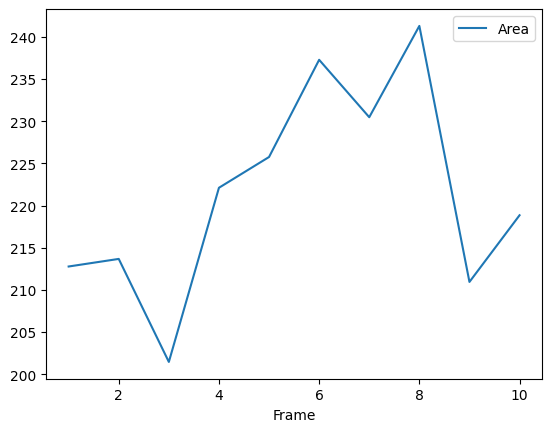

In [27]:
ax = df.plot(x='Frame', y='Area')

In [7]:
misc_path = f"{directory_path}misc/"

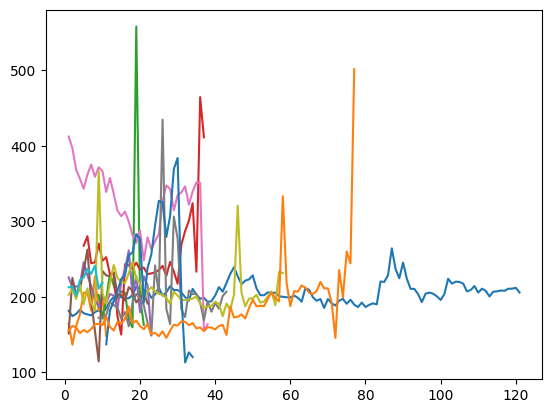

In [33]:
cells_desired = [46,35,28,66,4,73,20,47,38,12,82,27]
for i in cells_desired:
    df= pandas.read_csv(f"{misc_path}cell{i}_numbers.csv")
    plt.plot(df['Frame'], df['Area'], label=i)

In [ ]:
for file_path in file_list:
    image = ij.io().open(file_path)
    ij.ui().show(image)
    imp = ij.py.to_imageplus(image)
    f_name = os.path.basename(file_path)
    f_name = os.path.splitext(f_name)[0]
    input_ROI = Path(f"{folder_path}/{f_name}.zip")
    rm.open(f"{input_ROI}")
    Measure = """
    setAutoThreshold("Default dark no-reset");
    run("Threshold...");
    setThreshold(15, 255);
    setOption("BlackBackground", true);
    run("Convert to Mask", "black");
    run("Set Scale...", "distance=1024 known=202.83 unit=µm");
    nbArea=roiManager("count")
    for (i=0; i<nbArea; i++) {
            roiManager("Select", i);
            run("Set Measurements...", "area limit redirect=None decimal=2");
            run("Analyze Particles...", "summarize stack");
    }
    title = Table.title();
    selectWindow(title);
    Table.rename(title, "Results");
    array1 = newArray("0");
    for (i=1;i<roiManager("count");i++){
    array1 = Array.concat(array1,i);
    }
    roiManager("select", array1);
    roiManager("Delete");
    close("*");
    
    """
    ij.py.run_macro(Measure)

In [11]:
file_pattern = os.path.join(directory_path+"misc/", "*.csv")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    df = pandas.read_csv(file_path)
    dists = [0]
    speeds = [0]
    for i in range(1, len(df)):
        currx = df.at[i, "X"]
        curry = df.at[i, "Y"]
        prevx = df.at[i-1, "X"]
        prevy = df.at[i-1, "Y"]
        dist = math.sqrt((currx-prevx)**2 + (curry-prevy)**2)
        speed = dist / 5 ### REMOVE HARD CODED TIME FROM HERE LATER
        dists.append(dist)
        speeds.append(speed)
    df['Distance Traveled'] = dists
    df['Speed'] = speeds
    df.to_csv(file_path)


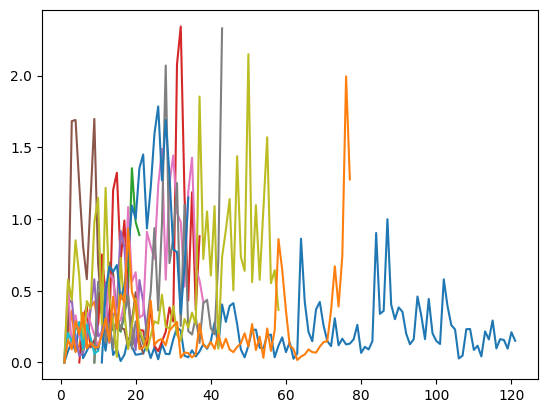

In [12]:
cells_desired = [46,35,28,66,4,73,20,47,38,12,82,27]
for i in cells_desired:
    df= pandas.read_csv(f"{misc_path}cell{i}_numbers.csv")
    plt.plot(df['Frame'], df['Speed'], label=i)

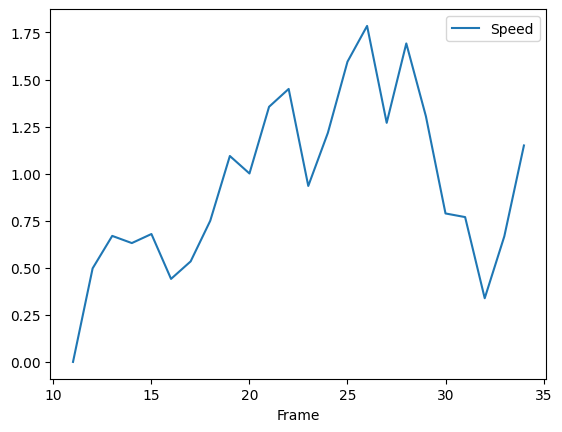

In [25]:
data_path = f"{directory_path}misc/cell82_numbers.csv"
df = pandas.read_csv(data_path)
ax = df.plot(x='Frame', y='Speed')

In [ ]:
def measure(directory_path, sum_channels, tracks_csv, cells_desired):
    out = directory_path+"/measurement/"
    if not os.path.exists(out):
        os.makedirs(out)
    imp = ij.IJ.openImage(sum_channels)
    imp.show()
    set_string = f'Set Measurements...'
    measure_string = f'integrated stack redirect=None decimal=2'
    ij.IJ.run(set_string, measure_string)
    df = pandas.read_csv(tracks_csv, header=None)
    for cell_desired in cells_desired:
        nums = []
        if isinstance(cell_desired, int):
            row = df.iloc[cell_desired-1]
            nums = row[0].split(", ")
        elif isinstance(cell_desired, list):
            for c in cell_desired:
                row = df.iloc[c-1]
                nums += row[0].split(", ")
        arr = []
        for x in nums:
            arr.append(int(x))
        for i in range(len(arr)):
            cell = arr[i]
            roi = rm.getRoi(cell-1)
            roi2 = rm.select(cell-1)
            ij.IJ.run('Measure')
        output = out+"LV_cell_"+str(cell_desired)+".csv"
        saving = ij.IJ.saveAs("Results", output)
        ij.IJ.run("Clear Results")
    return out

In [ ]:
measuremment = 